![https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png](https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png)

In [6]:
!pip install invertedai==0.0.3
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import invertedai as iai
clear_output()

# Provide your API key

In [7]:
iai.add_apikey("")

# Specify the location

In [8]:
location = "canada:vancouver:ubc_roundabout"

 # Set the simulation length (milliseconds)

In [9]:
simulation_length = 30 

# Preview the map location

(None, <matplotlib.image.AxesImage at 0x7fe8126b8fa0>)

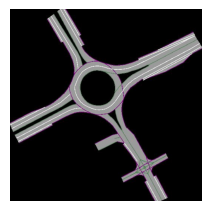

In [10]:
rendered_map = iai.location_info(location=location).birdview_image.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(2, 2))
ax.set_axis_off(), ax.imshow(rendered_map)

# Initialize the simulation

In [16]:
simulation = iai.BasicCosimulation(
    location=location,
    agent_count=10,
    render_birdview=True,
)

Unable to spawn a scenario for 10 agents,  8 spawned instead.


# Start the simulation

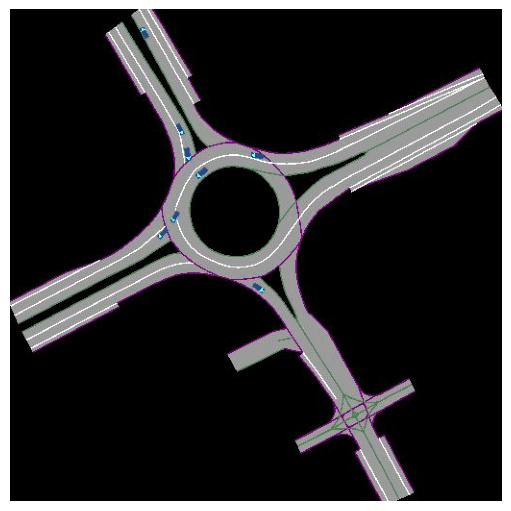

In [17]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5))
ax.set_axis_off()
frames = []
for t in range(simulation_length):
    simulation.step(current_ego_agent_states=[])
    birdview = simulation.birdview.decode()
    frames.append(birdview)
    ax.imshow(frames[-1])
    display(plt.gcf())
    clear_output(wait=True)  

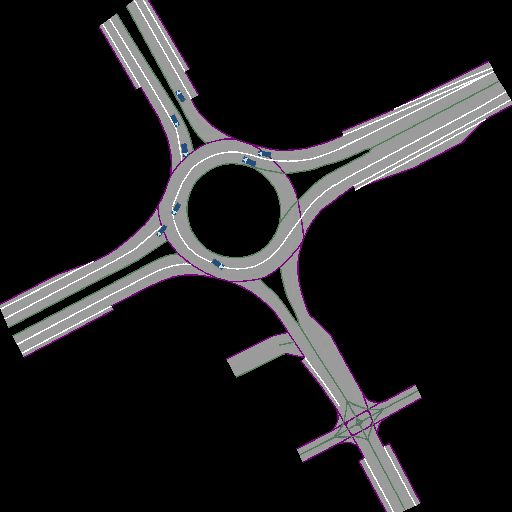

In [18]:
imageio.mimsave("iai-drive.gif", np.array(frames), format="GIF-PIL")
Image(open('iai-drive.gif','rb').read())